## Testing Dataset - Ground Truth Evaluation

This notebook is dedicated to evaluating the ground truth of the dataset from datasets ds_dir.

In [1]:
# Import required modules for file processing and comparison
import os
from time import time
from scsc import Compare
import pandas as pd

files_path = os.path.abspath(os.getcwd())
parent_path = os.path.dirname(files_path)


def get_truth_and_predicted_values(ds_dir, ds_sub_dir, csv_name, method="csim"):
    """
    NOTE:
    Change the csv_path to the location of your dataset if it's different from the default path.
    The dataset should be in the format of a CSV file with columns 'File_1', 'File_2', and 'Label'
    where 'Label' indicates whether the pair of files are similar (1) or not (0).
    """

    # Calculating execution time for the entire process
    import time
    start_time = time.time()

    csv_path = os.path.join(parent_path, ds_dir, ds_sub_dir, csv_name)

    balanced_df = pd.read_csv(csv_path)

    scores_arr = []
    predicted_values = []
    truth_values = balanced_df["Label"].tolist()
    THRESHOLD = (
        0.70  # Set a threshold for similarity score to classify pairs as similar or not
    )

    def get_content_from_path(path):
        with open(path, "r") as file:
            return file.read()

    for row in balanced_df.itertuples():
        f1_name, f2_name = row.File_1, row.File_2
        f1_path = os.path.join(
            parent_path, ds_dir, ds_sub_dir, f1_name
        )  # Change the path if your files are located in a different ds_dir
        f2_path = os.path.join(
            parent_path, ds_dir, ds_sub_dir, f2_name
        )  # Change the path if your files are located in a different ds_dir

        content1 = get_content_from_path(f1_path)
        content2 = get_content_from_path(f2_path)
        score = Compare(content1, content2, method=method)
        scores_arr.append(score)
        predicted_values.append(1 if score >= THRESHOLD else 0)

    endtime = time.time()
    print(f"Execution Time: {endtime - start_time:.2f} segundos")
    print(f"Total pairs processed: {len(truth_values)}")
    

    return truth_values, predicted_values, scores_arr


import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
import seaborn as sns


def calculate_metrics(true_values, predicted_values):
    # Ensure that the labels are ordered as [1, 0] to maintain consistency in the confusion matrix
    matrix = confusion_matrix(true_values, predicted_values, labels=[1, 0])
    accuracy = accuracy_score(true_values, predicted_values)
    precision = precision_score(true_values, predicted_values, zero_division=0)
    recall = recall_score(true_values, predicted_values, zero_division=0)
    f1 = f1_score(true_values, predicted_values, zero_division=0)
    return matrix, accuracy, precision, recall, f1


def plot_confusion_matrix(
    true_values, predicted_values, title=None, normalize=False, show_metrics=True
):

    matrix, accuracy, precision, recall, f1 = calculate_metrics(
        true_values, predicted_values
    )

    # Normalization by true class (row)
    if normalize:
        row_sums = matrix.sum(axis=1, keepdims=True)
        # Avoid division by zero
        row_sums[row_sums == 0] = 1
        display_matrix = matrix.astype(float) / row_sums
        fmt = ".2f"
        cbar_label = "Proporción"
    else:
        display_matrix = matrix
        fmt = "d"
        cbar_label = "Conteos"

    # Result: [[TP, FN], [FP, TN]]
    df_cm = pd.DataFrame(
        display_matrix,
        index=["Positivos Reales", "Negativos Reales"],
        columns=["Positivos Predichos", "Negativos Predichos"],
    )

    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        df_cm, annot=True, fmt=fmt, cmap="Blues", cbar_kws={"label": cbar_label}
    )
    plt.xlabel("Valores Predichos")
    plt.ylabel("Valores Reales")

    title = f"Matriz de Confusión | {title}" if title else "Matriz de Confusión"
    if show_metrics:
        title += f"\nAccuracy {accuracy:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}"
    plt.title(title)
    plt.tight_layout()
    plt.show()

import numpy as np

def plot_histogram(scores_arr, title=None, threshold=0.7):
    similarity_scores = np.array(scores_arr)

    bins = np.linspace(0, 1, 21)

    plt.figure(figsize=(8, 5))
    plt.hist(
        similarity_scores,
        bins=bins,
        density=True,
        edgecolor='black'
    )

    # Semantic regions
    plt.axvspan(0, threshold, alpha=0.1, color="red", label="No similar")
    plt.axvspan(threshold, 1, alpha=0.1, color="green", label="Similar")

    # Threshold
    plt.axvline(
        threshold,
        linestyle='--',
        linewidth=2,
        color='blue',
        label=f"Umbral θ = {threshold}"
    )

    # Stats
    mean = np.mean(similarity_scores)
    median = np.median(similarity_scores)

    plt.axvline(mean, linestyle=":", linewidth=2, label=f"Media = {mean:.2f}")
    plt.axvline(median, linestyle="-.", linewidth=2, label=f"Mediana = {median:.2f}")

    plt.xlabel("Índice de similitud")
    plt.ylabel("Densidad")
    plt.title(
        "Distribución del índice de similitud"
        + (f" | {title}" if title else "")
    )

    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()



Execution Time: 0.18 segundos
Total pairs processed: 36


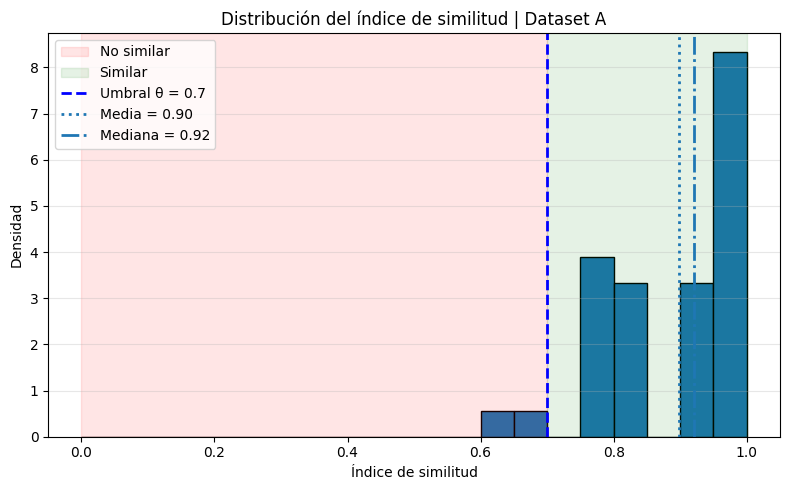

In [2]:
"""
    Controlled dataset evaluation
    All pair are similar
"""
controlled_truth_values, controlled_predicted_values, scores_arr = get_truth_and_predicted_values(
    ds_dir="datasets",
    ds_sub_dir="controlled",
    csv_name="controlled_dataset.csv",
    method="csim",
)
plot_histogram(scores_arr, title='Dataset A')

Execution Time: 1.21 segundos
Total pairs processed: 100


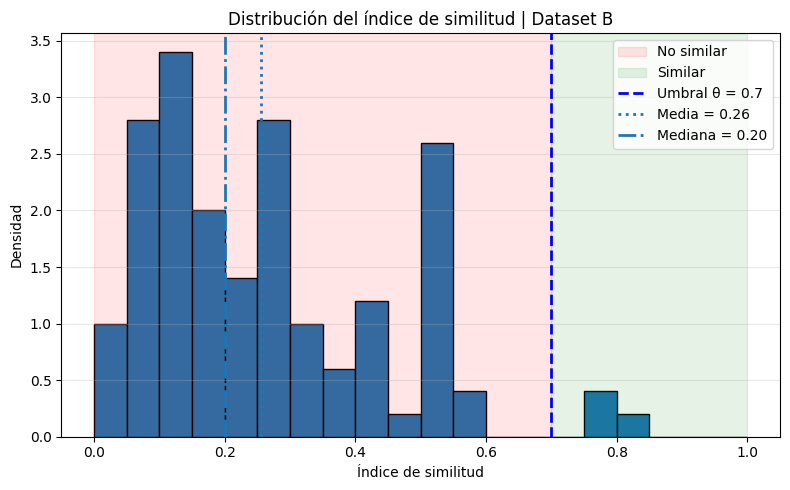

In [3]:
"""
    Kaggle dataset evaluation
    All pair are not similar
"""
kaggle_truth_values, kaggle_predicted_values, scores_arr= get_truth_and_predicted_values(
    ds_dir="datasets",
    ds_sub_dir="kaggle",
    csv_name="kaggle_dataset.csv",
    method="csim",
)

plot_histogram(scores_arr, title='Dataset B')

Execution Time: 1.62 segundos
Total pairs processed: 45


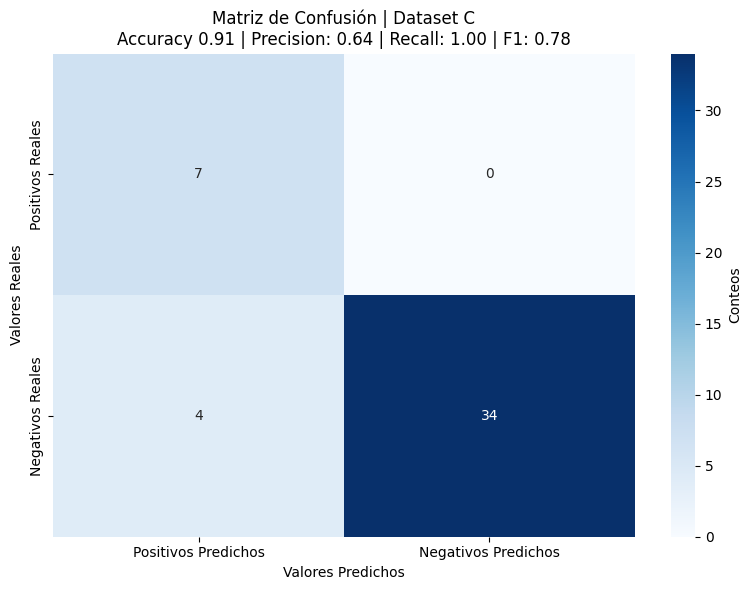

In [4]:
"""
    Small dataset evaluation
"""
small_truth_values, small_predicted_values, scores_arr = get_truth_and_predicted_values(
    ds_dir="datasets",
    ds_sub_dir="small",
    csv_name="small_dataset.csv",
    method="csim",
)
plot_confusion_matrix(
    small_truth_values, small_predicted_values, title='Dataset C', normalize=False, show_metrics=True
)

Syntax error in file None line 33:0  LEXER ERROR: inconsistent use of tabs and spaces in indentation
Syntax error in file None line 33:1 no viable alternative at input '\n ERROR: inconsistent use of tabs and spaces in indentation'
Syntax error in file None line 34:1 mismatched input '<INDENT>' expecting <EOF>


Execution Time: 5.41 segundos
Total pairs processed: 180


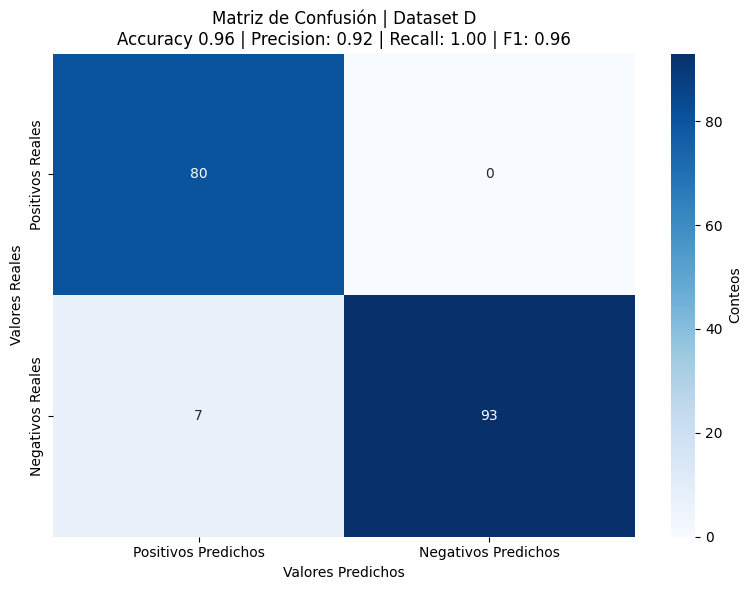

In [5]:
"""
    Medium dataset evaluation
    Balanced dataset with similar and non-similar pairs 100 positive and 100 negative
"""
medium_truth_values, medium_predicted_values, scores_arr = get_truth_and_predicted_values(
    ds_dir="datasets",
    ds_sub_dir="medium",
    csv_name="medium_dataset.csv",
    method="csim",
)
plot_confusion_matrix(
    medium_truth_values, medium_predicted_values, title='Dataset D', normalize=False, show_metrics=True
)

Execution Time: 4.55 segundos
Total pairs processed: 200


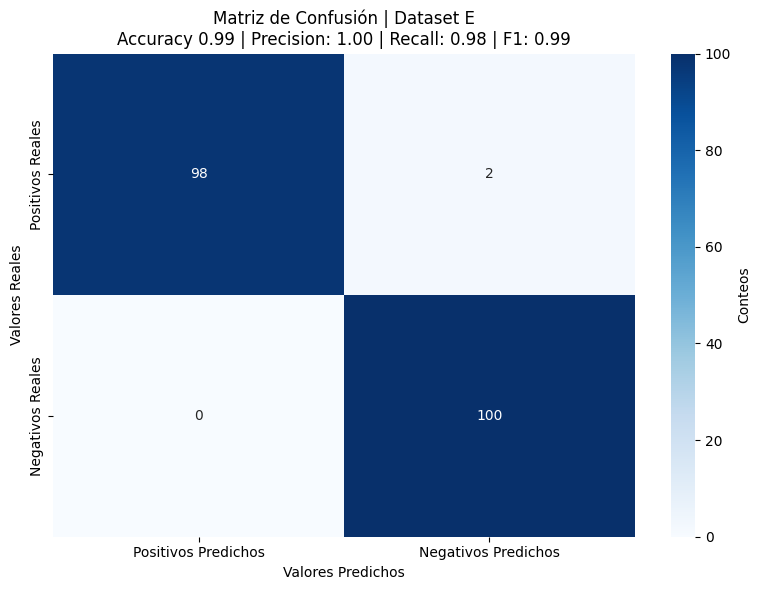

In [6]:
"""
    Large dataset evaluation
"""
large_truth_values, large_predicted_values, scores_arr = get_truth_and_predicted_values(
    ds_dir="datasets",
    ds_sub_dir="large",
    csv_name="large_dataset.csv",
    method="csim",
)
plot_confusion_matrix(
    large_truth_values, large_predicted_values, title='Dataset E', normalize=False, show_metrics=True
)

Execution Time: 10.98 segundos
Total pairs processed: 293


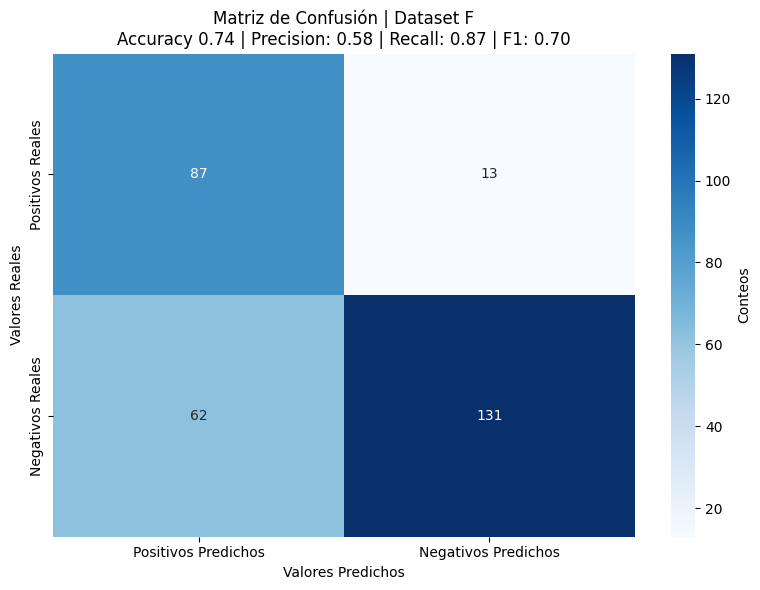

In [7]:
"""
    Kaggle IA dataset evaluation
    Dataset labeled from IA method
"""
kaggle_truth_values, kaggle_predicted_values, scores_arr= get_truth_and_predicted_values(
    ds_dir="datasets",
    ds_sub_dir="kaggleIA",
    csv_name="cheating_dataset.csv",
    method="csim",
)
plot_confusion_matrix(
    kaggle_truth_values, kaggle_predicted_values, title='Dataset F', normalize=False, show_metrics=True
)
